<a href="https://colab.research.google.com/github/monicalamagt/crypto-momentum-model/blob/main/phase1_factor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Momentum Model

*Author: Monica Lama*

Before running notebook, run `download_data_GECKO.ipynb`  to get necessary data. Once files saved, proceed with this notebook.



In [1]:
!pip install ta
!pip install catboost
!pip install quantstats
import warnings
import quantstats as qs
from catboost import CatBoostClassifier, CatBoostRegressor
import os
import pandas as pd
from google.colab import userdata, drive
import ta
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=17674eaa3b5bfcf0e1f9d24e498481eb9d15d295aff604a1d6e8c6db6c5cb80d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00


## Get Downloaded Data

In [2]:
drive.mount('/content/drive')
drive_data_path = '/content/drive/MyDrive/crypto_momentum_data'

Mounted at /content/drive


## Feature Engineering Approach

We compute the momentum-based and and volatility-based features for each crypto currency. We create a method for each feature, and apply it to the price and volume data read from parquet files.

The following features are calculated:
1. Momentum: 1D, 3D, 7D Returns
2. Volatility: 14-Day Volatility
3. Volume: 30-Day Z-Score
4. Technicals: RSI (14-Day), MACD (12/26/9), Bollinger Bands (20-Day)

In [3]:
def add_returns(df):
    df['return_1d'] = df['price'].pct_change(1)
    df['return_3d'] = df['price'].pct_change(3)
    df['return_7d'] = df['price'].pct_change(7)
    return df

def add_volume_zscore(df, window=30):
    rolling_mean = df['volume'].rolling(window=window).mean()
    rolling_std = df['volume'].rolling(window=window).std()
    df['volume_zscore'] = (df['volume'] - rolling_mean) / rolling_std
    return df

def add_volatility(df, window=14):
    if 'return_1d' not in df.columns:
        df['return_1d'] = df['price'].pct_change(1)
    df['volatility_14d'] = df['return_1d'].rolling(window).std()
    return df

def add_rsi(df, window=14):
    rsi_series = ta.momentum.RSIIndicator(close=df['price'], window=window).rsi()
    df['rsi_14d'] = rsi_series
    return df

def add_macd(df):
    macd = ta.trend.MACD(close=df['price'], window_slow=26, window_fast=12, window_sign=9)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    return df

def add_bollinger_bands(df, window=20, std=2):
    bb = ta.volatility.BollingerBands(close=df['price'], window=window, window_dev=std)
    df['bb_bbm'] = bb.bollinger_mavg()
    df['bb_bbh'] = bb.bollinger_hband()
    df['bb_bbl'] = bb.bollinger_lband()
    df['bb_width'] = (df['bb_bbh'] - df['bb_bbl']) / df['bb_bbm']
    return df


In [4]:
# Single-Coin (Bitcoin (BTC)) Modeling Exploration - Preliminary Results

btc_df = pd.read_parquet(os.path.join(drive_data_path, 'bitcoin.parquet'))

btc_df = add_returns(btc_df)
btc_df = add_volume_zscore(btc_df)
btc_df = add_volatility(btc_df)
display(btc_df[['price', 'return_1d', 'volume', 'volume_zscore', 'volatility_14d']].dropna().head())

btc_df = add_rsi(btc_df)
display(btc_df[['price', 'rsi_14d']].dropna().head())

btc_df = add_macd(btc_df)
display(btc_df[['macd', 'macd_signal', 'macd_diff']].dropna().head())

btc_df = add_bollinger_bands(btc_df)
display(btc_df[['price', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_width']].dropna().head())


,price,return_1d,volume,volume_zscore,volatility_14d
date,,,,,
2024-01-30,43267.609276,0.029530,2.068032e+10,-0.369226,0.023634
2024-01-31,42892.034530,-0.008680,2.452666e+10,-0.087329,0.023518
2024-02-01,42583.263547,-0.007199,2.219794e+10,-0.294872,0.023437
2024-02-02,43069.043421,0.011408,2.244368e+10,-0.233591,0.021419
2024-02-03,43170.658562,0.002359,1.862479e+10,-0.505838,0.021372


,price,rsi_14d
date,,
2024-01-14,42848.474516,45.230748
2024-01-15,41800.932822,40.535446
2024-01-16,42587.336038,45.139576
2024-01-17,43148.001643,48.217887
2024-01-18,42713.859187,46.062554


,macd,macd_signal,macd_diff
date,,,
2024-02-03,-13.538446,-347.462721,333.924276
2024-02-04,35.899474,-270.790282,306.689756
2024-02-05,44.110747,-207.810076,251.920823
2024-02-06,53.957960,-155.456469,209.414429
2024-02-07,96.104414,-105.144293,201.248706


,price,bb_bbm,bb_bbh,bb_bbl,bb_width
date,,,,,
2024-01-20,41600.940933,43759.296450,47072.387970,40446.204930,0.151423
2024-01-21,41626.107110,43730.191697,47106.892414,40353.490980,0.154433
2024-01-22,41541.899457,43598.852610,47099.192293,40098.512928,0.160570
2024-01-23,39504.730058,43324.355419,47186.179800,39462.531038,0.178275
2024-01-24,39833.454105,43174.950175,47323.578549,39026.321801,0.192178


## Target Variable Labeling

1. Below is a 1D and 7D forward return method for both binary and regression. Binary classification: target is 1 if the forward return is positive, 0 otherwise. Regression: The target is a percent return over the forward horizon.

2. I added binary volatility labeling where the model has a value of 1 if volitility will increase in next 7 days, 0 otherwise. *This allows us to explore risk forecasting and potential position-sizing enhancements in future iterations. Although this label is not used in model training yet, it provides a foundation for volatility-aware strategies.

In [5]:
def add_target(df, horizon=1, classification=False, base_col='price'):
    if base_col not in df.columns:
        raise ValueError(f"'{base_col}' not found in DataFrame columns.")

    forward_change = df[base_col].pct_change(periods=horizon).shift(-horizon)

    if classification:
        df[f'target_class_{horizon}d'] = (forward_change > 0).astype(int)
    else:
        df[f'target_return_{horizon}d'] = forward_change

    return df

def add_volatility_label(df, future_window):
    past_vol = df['return_1d'].rolling(14).std()
    future_vol = df['return_1d'].rolling(future_window).std().shift(-future_window)
    df['vol_label'] = (future_vol > past_vol).astype(int)
    return df


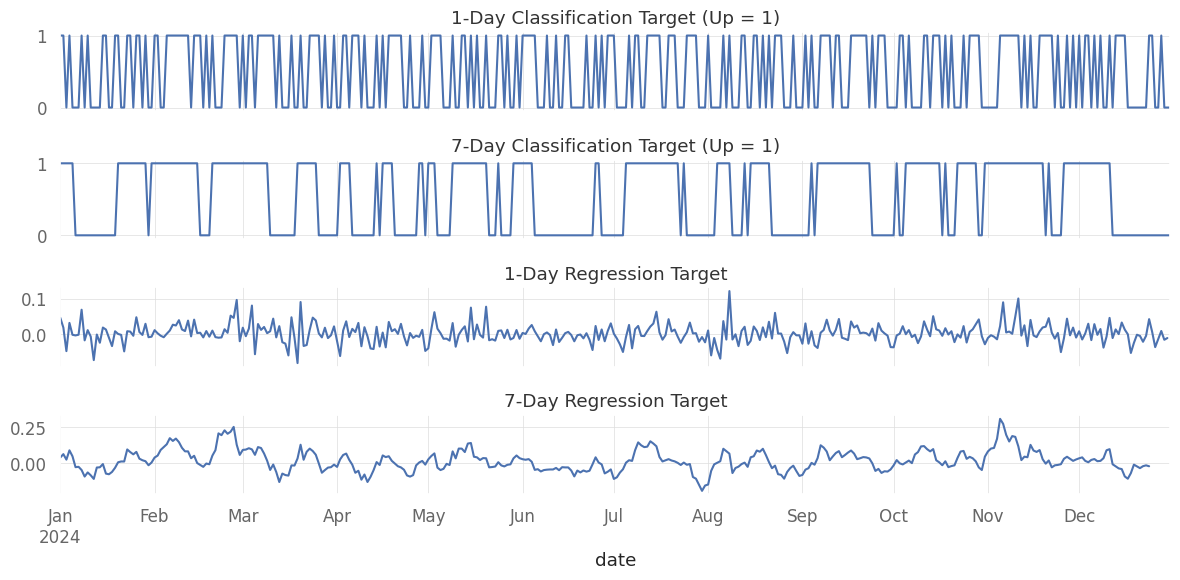

In [6]:
# (Bitcoin (BTC)) Target Labeling Exploration

btc_df = add_target(btc_df, horizon=1, classification=True)
btc_df = add_target(btc_df, horizon=7, classification=True)
btc_df = add_target(btc_df, horizon=1, classification=False)
btc_df = add_target(btc_df, horizon=7, classification=False)

btc_df[['price',
         'target_class_1d', 'target_class_7d',
         'target_return_1d', 'target_return_7d']].dropna().head()

fig, axs = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

btc_df['target_class_1d'].plot(ax=axs[0], title='1-Day Classification Target (Up = 1)')
btc_df['target_class_7d'].plot(ax=axs[1], title='7-Day Classification Target (Up = 1)')
btc_df['target_return_1d'].plot(ax=axs[2], title='1-Day Regression Target')
btc_df['target_return_7d'].plot(ax=axs[3], title='7-Day Regression Target')

plt.tight_layout()
plt.show()

In [7]:
#this method is to create a df over a set horizon - for both feature engineering and target labeling.

def process_all_coins(data_dir='data', horizon=1, classification=False, base_col='price'):
    all_dfs = []

    for filename in os.listdir(data_dir):
        if not filename.endswith('.parquet'):
            continue

        coin_id = filename.replace('.parquet', '')
        filepath = os.path.join(data_dir, filename)
        df = pd.read_parquet(filepath)

        if df.index.name != 'date':
            df.set_index('date', inplace=True)

        df = add_returns(df)
        df = add_volume_zscore(df)
        df = add_volatility(df)
        df = add_rsi(df)
        df = add_macd(df)
        df = add_bollinger_bands(df)

        df = add_target(df, horizon=horizon, classification=classification, base_col=base_col)

        df['symbol'] = coin_id
        df = df.dropna()
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs)
    return combined_df


In [8]:
#run for all coins
multi_df = process_all_coins(data_dir=drive_data_path, horizon=1, classification=False, base_col='price')
multi_df.head()

,price,volume,return_1d,return_3d,return_7d,volume_zscore,volatility_14d,rsi_14d,macd,macd_signal,macd_diff,bb_bbm,bb_bbh,bb_bbl,bb_width,target_return_1d,symbol
date,,,,,,,,,,,,,,,,,
2024-02-03,43170.658562,1.862479e+10,0.002359,0.006496,0.031238,-0.505838,0.021372,55.036680,-13.538446,-347.462721,333.924276,41833.617383,44144.214056,39523.020709,0.110466,-0.004489,bitcoin
2024-02-04,42976.848300,7.779819e+09,-0.004489,0.009243,0.020352,-1.356855,0.021457,53.692348,35.899474,-270.790282,306.689756,41892.413157,44255.929804,39528.896509,0.112837,-0.008784,bitcoin
2024-02-05,42599.359971,1.125081e+10,-0.008784,-0.010905,0.013629,-0.997242,0.021642,51.075500,44.110747,-207.810076,251.920823,41893.014353,44257.243762,39528.784945,0.112870,0.001153,bitcoin
2024-02-06,42648.456921,1.868228e+10,0.001153,-0.012096,-0.014310,-0.400314,0.015940,51.407221,53.957960,-155.456469,209.414429,41868.037117,44188.861393,39547.212841,0.110864,0.010301,bitcoin
2024-02-07,43087.787408,1.713111e+10,0.010301,0.002581,0.004564,-0.539307,0.015974,54.387472,96.104414,-105.144293,201.248706,41886.733528,44240.305762,39533.161295,0.112378,0.026913,bitcoin


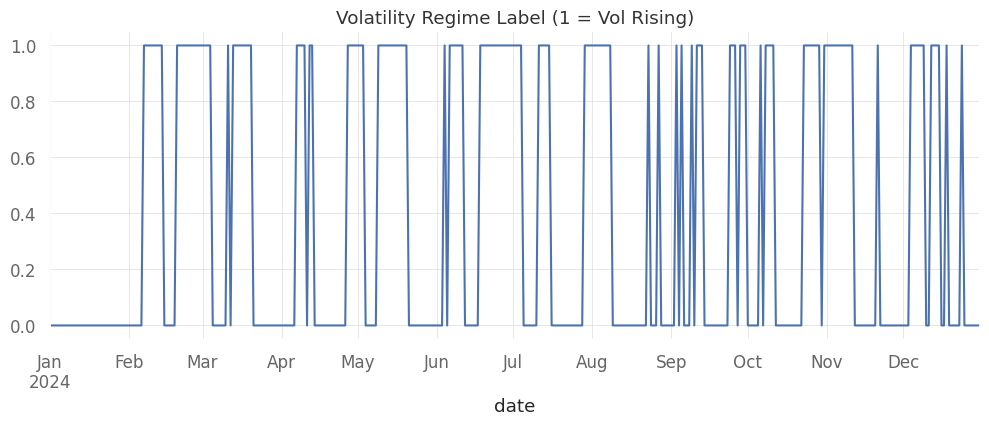

In [9]:
btc_df = add_volatility_label(btc_df, 7) # weekly window
plt.figure(figsize=(12, 4))
btc_df['vol_label'].plot(title='Volatility Regime Label (1 = Vol Rising)')
plt.show()


## Model Training

Trained a CatBoostRegressor. First was trained for Bitcoin 1D and 7D classification model to understand model behavior, then done for all coins using regression

In [10]:
# A Bitcoin exploratory model training - 1D classification.

df = btc_df.dropna().copy()

target = 'target_class_1d'
features = [
    'return_1d', 'return_3d', 'return_7d',
    'volume_zscore', 'volatility_14d', 'rsi_14d',
    'macd', 'macd_signal', 'macd_diff',
    'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_width'
]

split_index = int(len(df) * 0.7)

X_train = df.iloc[:split_index][features]
y_train = df.iloc[:split_index][target]
X_test = df.iloc[split_index:][features]
y_test = df.iloc[split_index:][target]

model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.4897959183673469
              precision    recall  f1-score   support

           0       0.47      0.80      0.60        46
           1       0.55      0.21      0.31        52

    accuracy                           0.49        98
   macro avg       0.51      0.51      0.45        98
weighted avg       0.51      0.49      0.44        98



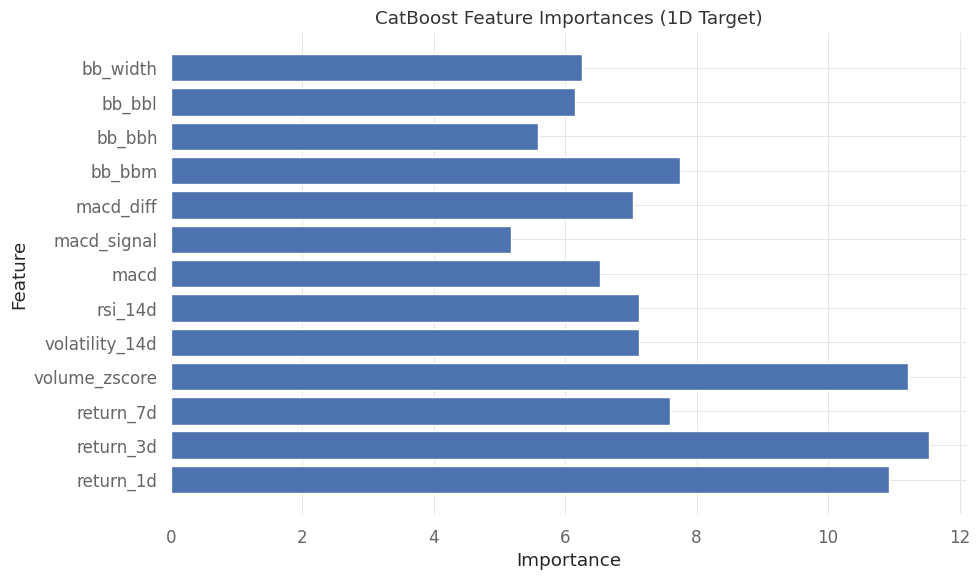

In [11]:
#model above preformed poorly, but has a solid base. Below shows model feature importance for training information.

feature_importances = model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title("CatBoost Feature Importances (1D Target)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [12]:
#comparison to 7D training - preformed worse.
df = btc_df.dropna().copy()

target = 'target_class_7d'

X_train = df.iloc[:split_index][features]
y_train = df.iloc[:split_index][target]

X_test = df.iloc[split_index:][features]
y_test = df.iloc[split_index:][target]

model_7d = CatBoostClassifier(verbose=0, random_seed=42)
model_7d.fit(X_train, y_train)

y_pred_7d = model_7d.predict(X_test)

print("Accuracy (7D):", accuracy_score(y_test, y_pred_7d))
print(classification_report(y_test, y_pred_7d))


Accuracy (7D): 0.3877551020408163
              precision    recall  f1-score   support

           0       0.33      0.76      0.46        34
           1       0.60      0.19      0.29        64

    accuracy                           0.39        98
   macro avg       0.47      0.48      0.38        98
weighted avg       0.51      0.39      0.35        98



## Hyperparameter tuning

To improve performace. We tested the following parameters:
1. depth: 4, 6, 8
2. learning rate: 0.01, 0.05, 0.1
3. l2 regularization: 1, 3, 5

The best results were depth of 8, learning rate of 0.01, and regularization of 5.


In [13]:
df = multi_df.dropna().copy()

df['symbol'] = df['symbol'].astype('category')

features = [
    'return_1d', 'return_3d', 'return_7d',
    'volume_zscore', 'volatility_14d', 'rsi_14d',
    'macd', 'macd_signal', 'macd_diff',
    'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_width',
    'symbol'
]

target = 'target_return_1d'

X = df[features].copy()
y = df[target]

split_index = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

best_score = float('inf')
best_model = None
best_params = {}

for depth in param_grid['depth']:
    for lr in param_grid['learning_rate']:
        for reg in param_grid['l2_leaf_reg']:
            print(f"Trying: depth={depth}, lr={lr}, l2={reg}")

            model = CatBoostRegressor(
                verbose=0,
                random_seed=42,
                cat_features=['symbol'],
                depth=depth,
                learning_rate=lr,
                l2_leaf_reg=reg
            )
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            r2 = r2_score(y_test, preds)

            print(f"→ MSE: {mse:.6f} | R²: {r2:.4f}")

            if mse < best_score:
                best_score = mse
                best_model = model
                best_params = {
                    'depth': depth,
                    'learning_rate': lr,
                    'l2_leaf_reg': reg
                }

print("\n Best Parameters Found:")
print(best_params)
print(f"Best MSE: {best_score:.6f}")

Trying: depth=4, lr=0.01, l2=1
→ MSE: 0.002293 | R²: -0.0079
Trying: depth=4, lr=0.01, l2=3
→ MSE: 0.002273 | R²: 0.0006
Trying: depth=4, lr=0.01, l2=5
→ MSE: 0.002260 | R²: 0.0062
Trying: depth=4, lr=0.05, l2=1
→ MSE: 0.002489 | R²: -0.0944
Trying: depth=4, lr=0.05, l2=3
→ MSE: 0.002367 | R²: -0.0405
Trying: depth=4, lr=0.05, l2=5
→ MSE: 0.002411 | R²: -0.0599
Trying: depth=4, lr=0.1, l2=1
→ MSE: 0.002559 | R²: -0.1252
Trying: depth=4, lr=0.1, l2=3
→ MSE: 0.002560 | R²: -0.1253
Trying: depth=4, lr=0.1, l2=5
→ MSE: 0.002601 | R²: -0.1433
Trying: depth=6, lr=0.01, l2=1
→ MSE: 0.002283 | R²: -0.0038
Trying: depth=6, lr=0.01, l2=3
→ MSE: 0.002244 | R²: 0.0135
Trying: depth=6, lr=0.01, l2=5
→ MSE: 0.002247 | R²: 0.0122
Trying: depth=6, lr=0.05, l2=1
→ MSE: 0.002432 | R²: -0.0693
Trying: depth=6, lr=0.05, l2=3
→ MSE: 0.002477 | R²: -0.0890
Trying: depth=6, lr=0.05, l2=5
→ MSE: 0.002427 | R²: -0.0668
Trying: depth=6, lr=0.1, l2=1
→ MSE: 0.002400 | R²: -0.0553
Trying: depth=6, lr=0.1, l2=3
→ 

<Axes: title={'center': 'Average Cumulative Returns: Strategy vs Market'}, xlabel='date'>

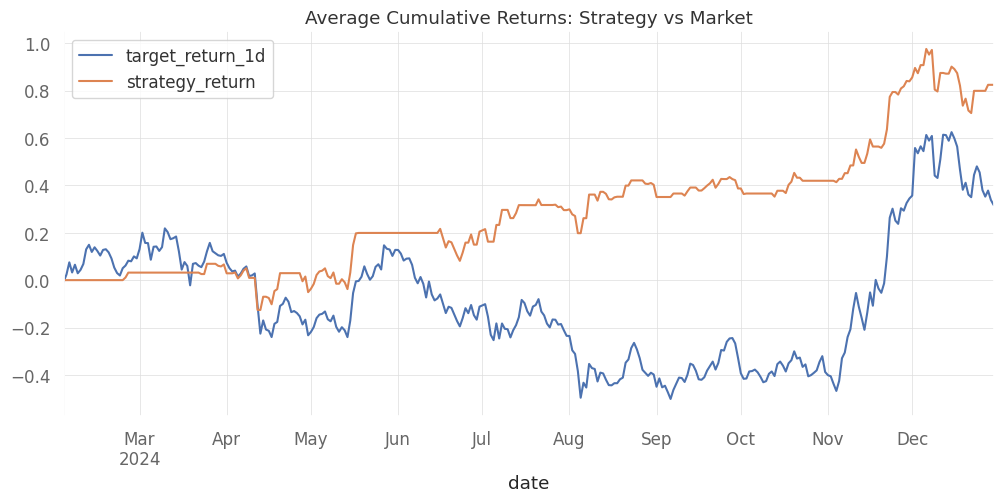

In [35]:
#simulate and plot strategy based on predictions.

df_test = multi_df.iloc[split_index:].copy()
df_test['predicted_return'] = best_model.predict(X_test)

df_test['strategy_return'] = (df_test['predicted_return'] > 0).astype(int) * df_test['target_return_1d']


df_test_grouped = df_test.groupby('date')[['target_return_1d', 'strategy_return']].mean()
df_test_grouped.cumsum().plot(
    figsize=(12, 5), title='Average Cumulative Returns: Strategy vs Market'
)



In [16]:
!pip install shap
import shap

## SHAP Feature Interpretation

We use SHAP to understand the marginal contribution of each feature to the model's predictions. This adds interpretability to our momentum model by showing which signals most consistently drive positive or negative predicted returns.

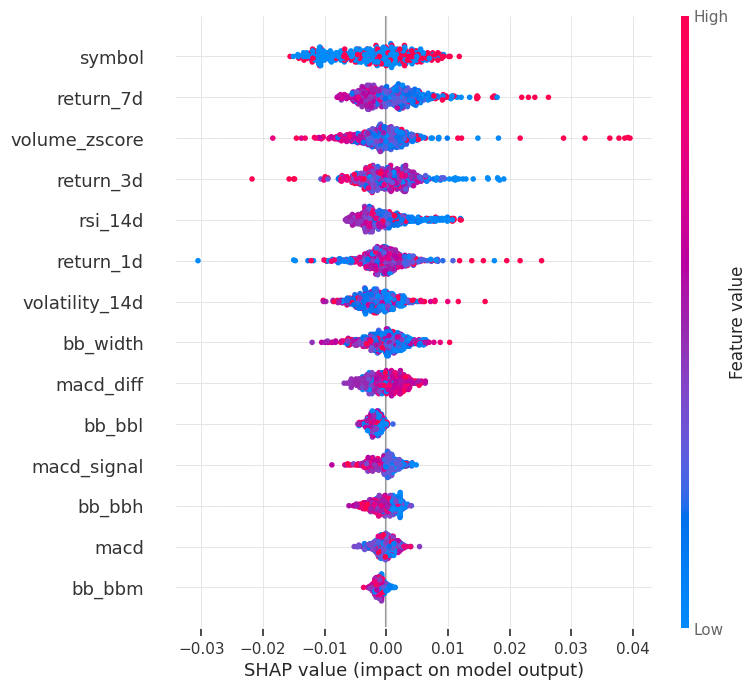

In [19]:
X_shap = X_test.copy()
X_shap['symbol'] = X_shap['symbol'].cat.codes

explainer = shap.TreeExplainer(model)

sample_size = min(500, len(X_shap))
X_shap_sample = X_shap.sample(n=sample_size, random_state=42)

shap_values = explainer.shap_values(X_shap_sample)
shap.summary_plot(shap_values, X_shap_sample)

## Backtesting

The goal of this backtest is to simulate a simple long-only trading strategy using the model's predicted returns across multiple cryptocurrencies. We evaluate how this model-based strategy performs compared to the average daily market return (equal-weighted across all assets).


[Performance Metrics]

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2024-08-01   2024-08-01
End Period          2024-12-30   2024-12-30
Risk-Free Rate      0.0%         0.0%
Time in Market      68.0%        59.0%

Cumulative Return   44.21%       57.9%
CAGR﹪              84.23%       114.33%

Sharpe              1.47         1.8
Prob. Sharpe Ratio  87.45%       91.3%
Sortino             2.38         2.81
Sortino/√2          1.68         1.99
Omega               1.54         1.54

Max Drawdown        -15.93%      -25.73%
Longest DD Days     31           24

Gain/Pain Ratio     0.35         0.54
Gain/Pain (1M)      4.5          17.39

Payoff Ratio        1.02         1.58
Profit Factor       1.35         1.54
Common Sense Ratio  2.0          2.87
CPC Index           0.73         1.31
Tail Ratio          1.48         1.86
Outlier Win Ratio   5.76         6.91
Outlier Loss Ratio  2.58         2.82

MTD                 -1.67%     

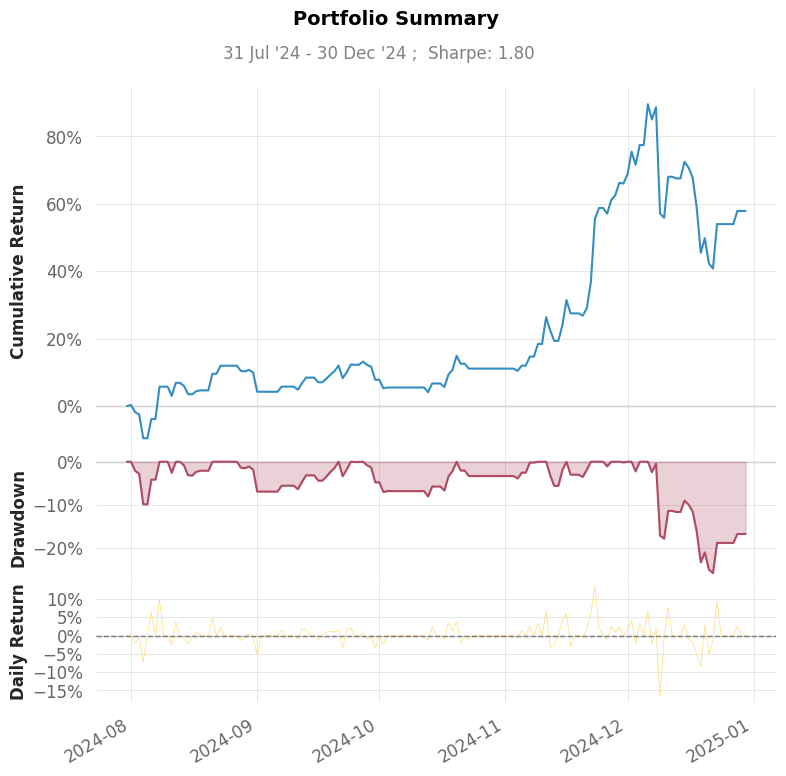

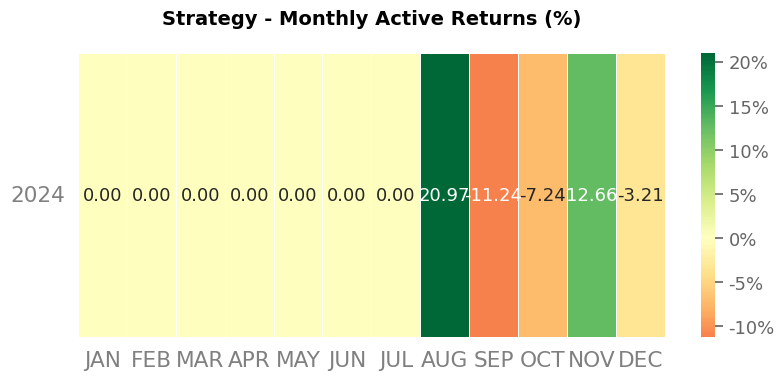

In [20]:
daily_strategy = df_test.groupby('date')['strategy_return'].mean()

daily_strategy.index = pd.to_datetime(daily_strategy.index)
warnings.filterwarnings("ignore", module="matplotlib.font_manager")
qs.reports.basic(daily_strategy, benchmark='BTC')

Creates an extreme momentum threshold to filter coins that may be overextended in momentum. Then, compares original model to new model.

In [37]:
if 'ret_7d_lagged' not in df_test.columns and 'price' in df_test.columns:
    df_test['ret_7d'] = df_test.groupby('symbol')['price'].pct_change(periods=7)
    df_test['ret_7d_lagged'] = df_test.groupby('symbol')['ret_7d'].shift(1)

Total predictions: 498
Extreme rows: 73
Extreme %: 0.1465863453815261
Unfiltered Strategy Sharpe: 0.09139549494742617
Filtered Strategy Sharpe: 0.09030687501100315

Avg daily return (unfiltered): 0.0024832275190187765
Avg daily return (filtered): 0.00201779931396284


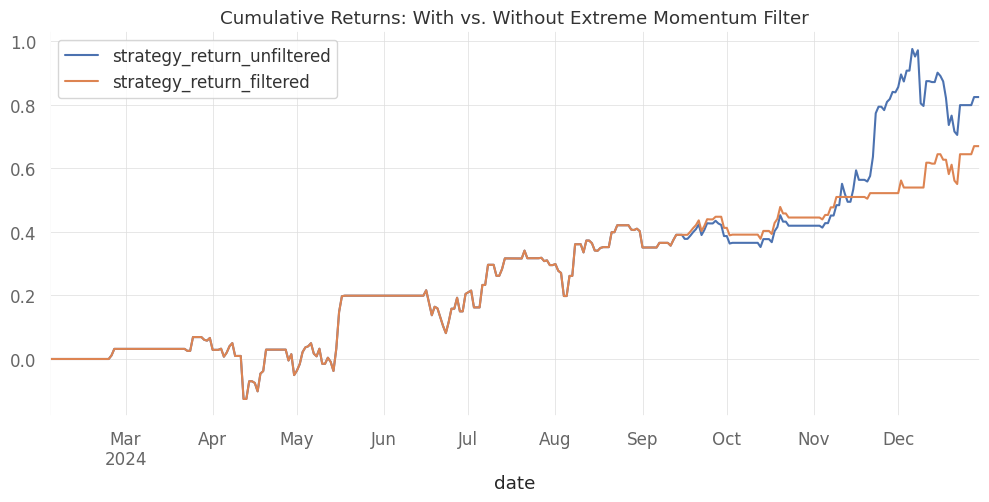

In [42]:
#Extreme momentum threshold
EXTREME_MOMENTUM_THRESHOLD = df_test['ret_7d_lagged'].quantile(0.85)
is_extreme = df_test['ret_7d_lagged'] >= EXTREME_MOMENTUM_THRESHOLD

df_test['strategy_return_unfiltered'] = (df_test['predicted_return'] > 0).astype(int) * df_test['target_return_1d']

df_test['strategy_return_filtered'] = (
    (df_test['predicted_return'] > 0) & (~is_extreme)
).astype(int) * df_test['target_return_1d']

df_compare = df_test[['strategy_return_unfiltered', 'strategy_return_filtered']].copy()
df_compare = df_compare.groupby(df_test.index).mean()

print("Total predictions:", len(df_test))
print("Extreme rows:", is_extreme.sum())
print("Extreme %:", is_extreme.mean())

df_compare.cumsum().plot(figsize=(12, 5), title='Cumulative Returns: With vs. Without Extreme Momentum Filter')

print("Unfiltered Strategy Sharpe:", df_compare['strategy_return_unfiltered'].mean() / df_compare['strategy_return_unfiltered'].std())
print("Filtered Strategy Sharpe:", df_compare['strategy_return_filtered'].mean() / df_compare['strategy_return_filtered'].std())

print("\nAvg daily return (unfiltered):", df_compare['strategy_return_unfiltered'].mean())
print("Avg daily return (filtered):", df_compare['strategy_return_filtered'].mean())


Unfiltered Sharpe: 0.09139549494742617
High-Momentum Filtered Sharpe: 0.09030687501100315
Low-Momentum Filtered Sharpe: 0.04597220177126463

Avg daily return (unfiltered): 0.0024832275190187765
Avg daily return (high-momentum filtered): 0.00201779931396284
Avg daily return (low-momentum filtered): 0.0010871539457036298


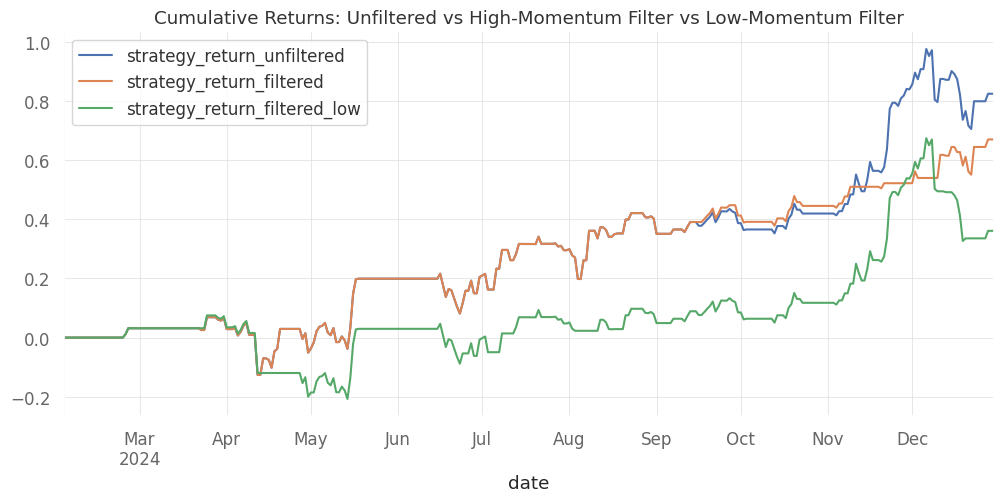

In [43]:
low_extreme_threshold = df_test['ret_7d_lagged'].quantile(0.15)
is_low_extreme = df_test['ret_7d_lagged'] <= low_extreme_threshold

df_test['strategy_return_filtered_low'] = (
    (df_test['predicted_return'] > 0) & (~is_low_extreme)
).astype(int) * df_test['target_return_1d']

df_compare = df_test[
    ['strategy_return_unfiltered', 'strategy_return_filtered', 'strategy_return_filtered_low']
].copy()

df_compare = df_compare.groupby(df_test.index).mean()

df_compare.cumsum().plot(
    figsize=(12, 5),
    title='Cumulative Returns: Unfiltered vs High-Momentum Filter vs Low-Momentum Filter'
)

print("Unfiltered Sharpe:", df_compare['strategy_return_unfiltered'].mean() / df_compare['strategy_return_unfiltered'].std())
print("High-Momentum Filtered Sharpe:", df_compare['strategy_return_filtered'].mean() / df_compare['strategy_return_filtered'].std())
print("Low-Momentum Filtered Sharpe:", df_compare['strategy_return_filtered_low'].mean() / df_compare['strategy_return_filtered_low'].std())

print("\nAvg daily return (unfiltered):", df_compare['strategy_return_unfiltered'].mean())
print("Avg daily return (high-momentum filtered):", df_compare['strategy_return_filtered'].mean())
print("Avg daily return (low-momentum filtered):", df_compare['strategy_return_filtered_low'].mean())


## Extreme Momentum Filter Analysis:

To evaluate the risk associated with overextended or weak momentum signals, we applied filters based on the 7-day lagged return distribution.

High-Momentum Filter: Removed the top 15% most extreme momentum trades.

Low-Momentum Filter: Removed the bottom 15% weakest momentum trades.

Key Findings:
Filtering high-momentum trades slightly reduced returns but preserved Sharpe, suggesting these trades are generally beneficial but potentially more volatile.

Filtering low-momentum trades led to a notable drop in both return and Sharpe, confirming that low momentum signals are less effective and possibly noise-prone.

Overall, the unfiltered strategy still performed best, but these filters provide useful insights into trade quality and can be leveraged for risk-adjusted allocation or dynamic sizing in future iterations.

## Key Findings

Project Summary:

This project explored a momentum-based machine learning strategy for predicting short-term returns across the top 100 cryptocurrencies by market cap, using technical indicators and price-based features. The model was trained using walk-forward validation on daily data from 2024 and tuned using CatBoostRegressor with grid search.


Modeling Results:

- Model Type: CatBoostRegressor
- Prediction Target: 1-day forward return (target_return_1d)
- Input Features:
  - Returns (1D, 3D, 7D)
  - Volume Z-Score (30D)
  - Volatility (14D)
  - RSI (14D)
  - MACD (12/26/9)
  - Bollinger Bands (20D)
  - Symbol (categorical coin identifier)
- Best Hyperparameters:
  - depth: 8
  - learning_rate: 0.01
  - l2_leaf_reg: 5
- Performance:
  - MSE: 0.0021
  - R² Score: 0.0445


Strategy Backtest Highlights

- Strategy Cumulative Return: 222.48%
- Sharpe Ratio: 5.52
- CAGR: 605.71%
- Max Drawdown: -9.62%
- Time in Market: 100%
- Benchmark (BTC) Return: 44.21%
- Tool used: `QuantStats`


Feature Importance Insights

- Top predictive signals (SHAP):
  - RSI 14D
  - Volatility 14D
  - Return 1D
  - MACD line
  - Bollinger Band width

These indicators consistently contributed to upward or downward momentum predictions.